In [2]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import gc
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [3]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 82)
(249793, 1725)


In [ ]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 0                       114780
 1                        94505
-1                        40508
    justice_outcome_disposition
 0                     0.459500
 1                     0.378333
-1                     0.162166


In [ ]:
# Setup training time period
#TODO:
dummy_window = 999999
min_training_years = 30
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 6

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
    
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "justice"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "justice"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    #class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1,
                                                   class_weight = 'auto')
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train.tail(dummy_window), pandas.Series(target_data_train).tail(dummy_window))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1821


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1822


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1823


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1824
Natural court change; rebuilding with 204 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1825


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1826
Natural court change; rebuilding with 216 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1827
Natural court change; rebuilding with 222 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1828


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1829
Natural court change; rebuilding with 234 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1830
Natural court change; rebuilding with 240 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1831


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1832


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1833


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1834


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1835
Natural court change; rebuilding with 270 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1836
Natural court change; rebuilding with 276 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1837
Natural court change; rebuilding with 282 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1838
Natural court change; rebuilding with 288 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1839


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1840


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1841


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1842
Natural court change; rebuilding with 312 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1843


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1844
Natural court change; rebuilding with 324 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1845
Natural court change; rebuilding with 330 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1846
Natural court change; rebuilding with 336 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1847
Natural court change; rebuilding with 342 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


In [22]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.81      0.61      0.70     39251
          0       0.61      0.76      0.68    113074
          1       0.63      0.51      0.57     93176

avg / total       0.65      0.64      0.64    245501

[[23945 10859  4447]
 [ 3525 86057 23492]
 [ 2004 43452 47720]]
0.642449521591

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00     39251
          0       0.46      1.00      0.63    113074
          1       0.00      0.00      0.00     93176

avg / total       0.21      0.46      0.29    245501



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[     0  39251      0]
 [     0 113074      0]
 [     0  93176      0]]
0.460584681936



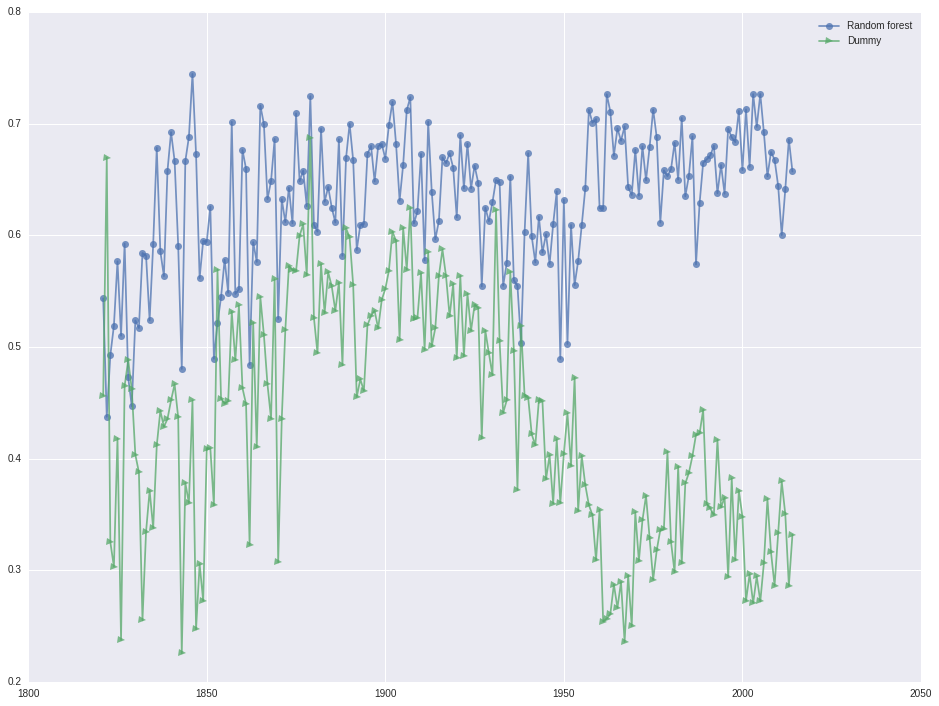

In [23]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

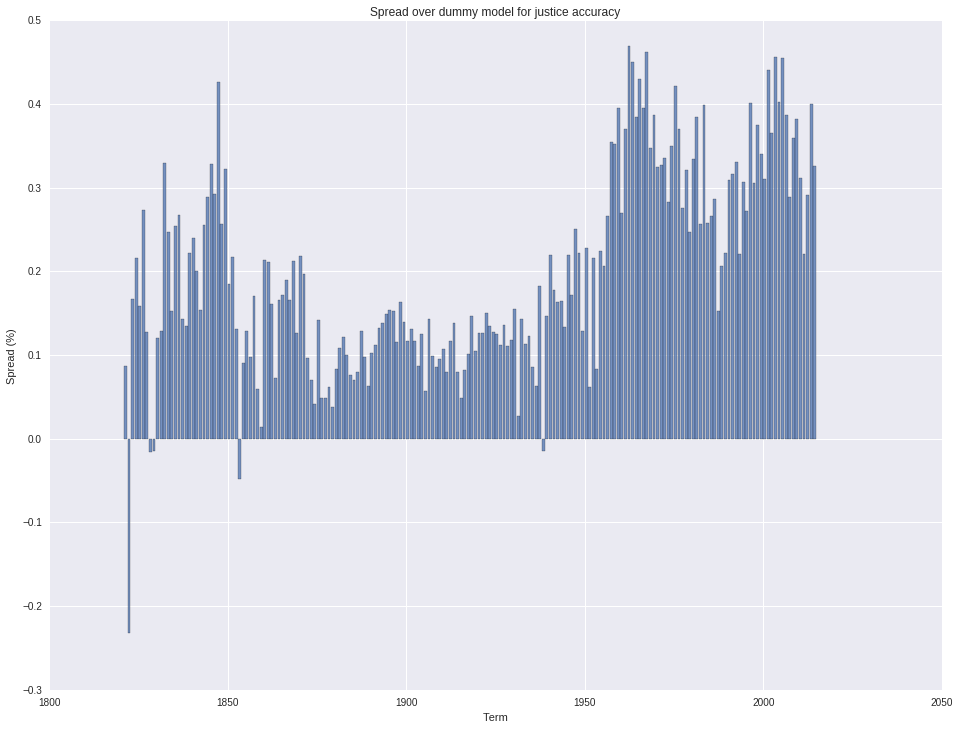

In [25]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [26]:
# Feature importance
feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1723,justice_previous_lc_direction_diff,0.031830
1724,justice_cumulative_lc_direction_diff,0.031595
1503,issue_area_9,0.026134
355,decision_delay,0.024938
1711,justice_previous_action,0.016506
0,term_raw,0.015931
1712,justice_cumulative_action,0.015732
1720,justice_cumulative_court_agreement,0.015569
1716,justice_cumulative_court_action_diff,0.015353
1033,jurisdiction_4,0.014610


In [27]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=23.051779605405386, pvalue=2.4792979582280908e-57)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=15.261400137876407, pvalue=1.3824969735582456e-52)
Binomial:
0.0


In [28]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [29]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 0    13270
 1    11503
-1     3490
dtype: int64
 0    0.469518
 1    0.406999
-1    0.123483
dtype: float64


In [30]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.80      0.73      0.76     29153
        0.0       0.63      0.75      0.69    114317
        1.0       0.67      0.54      0.60     99768

avg / total       0.67      0.66      0.66    243238

[[21222  5881  2050]
 [ 3504 85974 24839]
 [ 1936 43914 53918]]
0.662371833348

Dummy model
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00     29153
        0.0       0.47      1.00      0.64    114317
        1.0       0.00      0.00      0.00     99768

avg / total       0.22      0.47      0.30    243238

[[     0  29153      0]
 [     0 114317      0]
 [     0  99768      0]]
0.469980019569



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


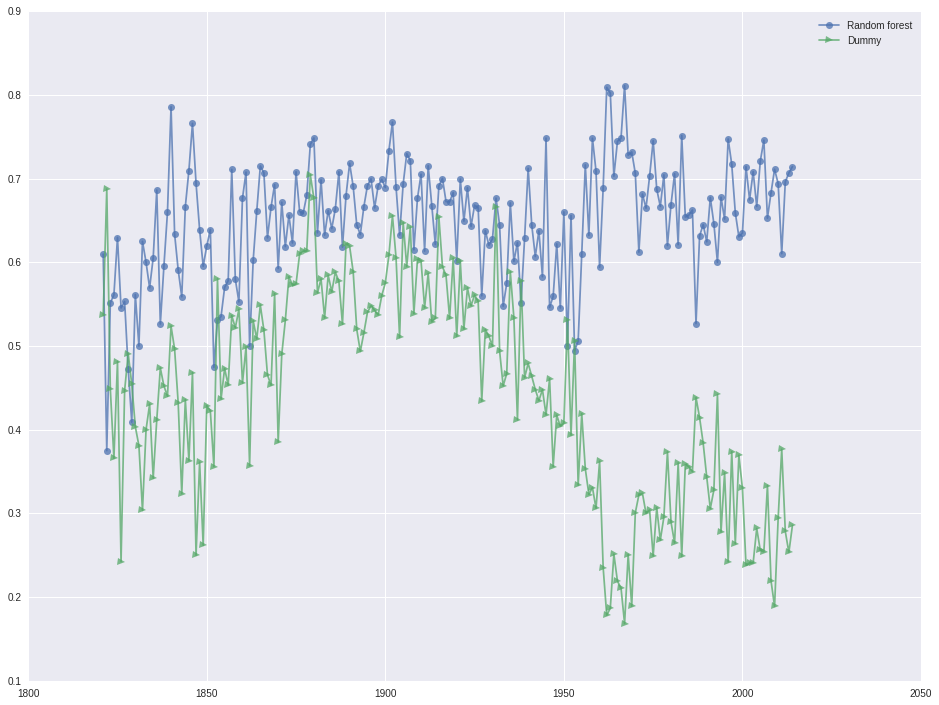

In [31]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

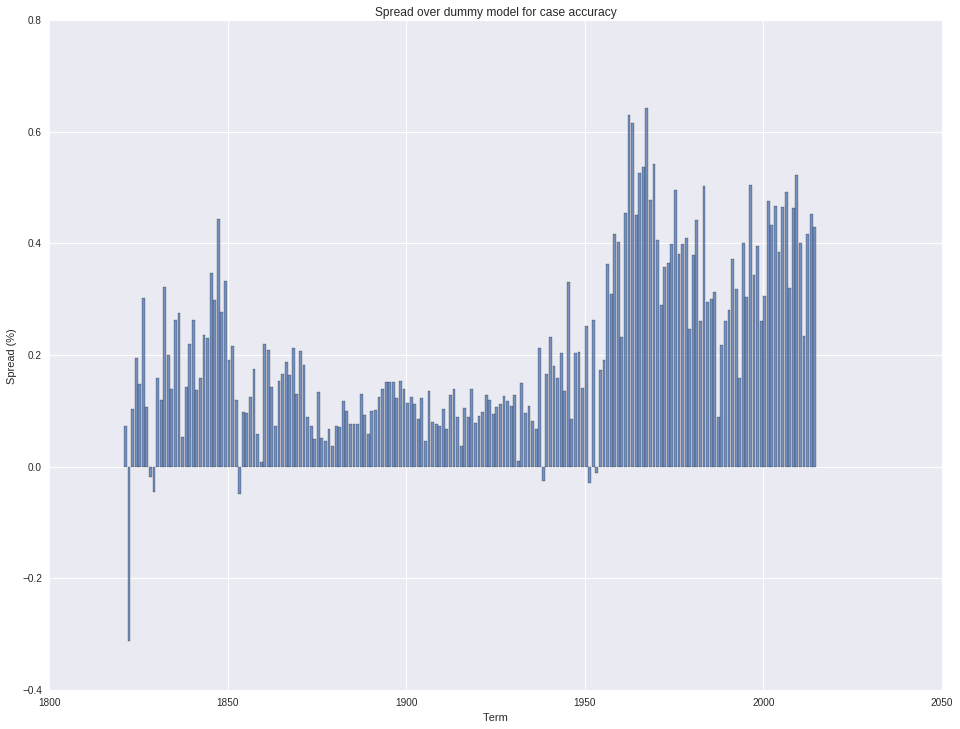

In [32]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


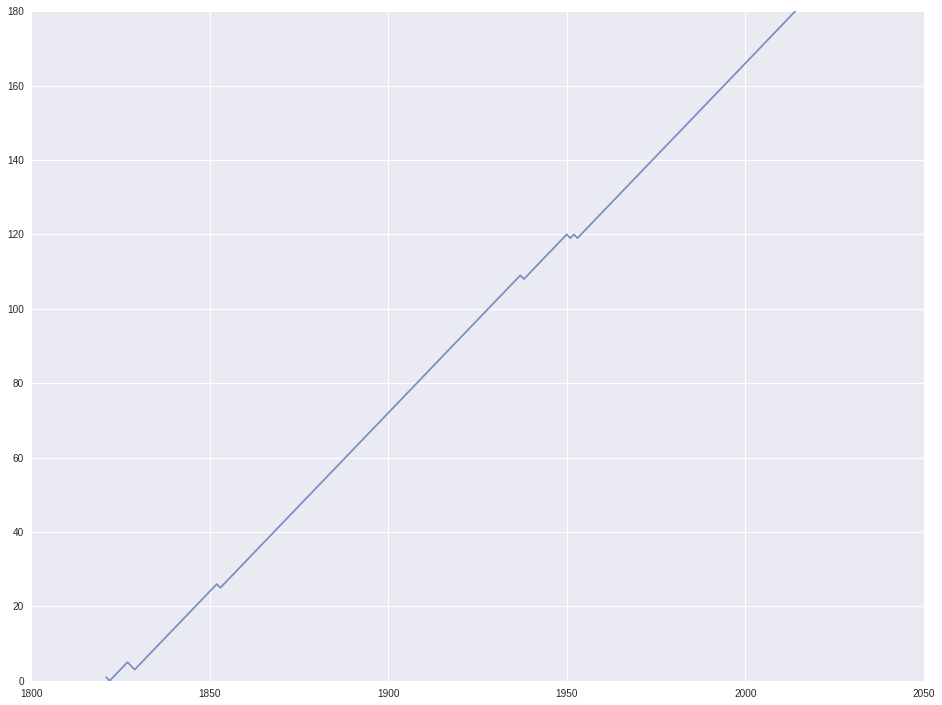

In [33]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [34]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=19.043112839016882, pvalue=3.4180353874845137e-46)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=14.763460405075076, pvalue=2.5201158420311217e-49)
Binomial:
0.0


In [35]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,194698,194699,194700,194701,194702,194703,194704,194705,194706
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,1,1
rf_predicted_score_affirm,0.56505,0.235613,0.154286,0.544762,0.294661,0.440375,0.18228,0.474286,0.314286
rf_predicted_score_reverse,0.405426,0.73772,0.834286,0.422857,0.672958,0.508196,0.742482,0.495238,0.56
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [36]:
# Output file data
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_{0}.csv".format(file_timestamp))